In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [56]:
song_data = pd.read_csv('playlists-v4-final.csv')

# Create the sorted dataframe, drop zeros, convert any categoricals
sort_data = song_data.sort_values('popularity_scores', ascending=False).reset_index()
ordered = sort_data.drop(['index', 'genre', 'id'], axis=1)
ordered.index = ordered.index + 1
ordered = ordered[ordered.popularity_scores > 0]

ordered[['mode', 'key', 'time_signature']] = \
    ordered[['mode', 'key', 'time_signature']].astype('category')

In [57]:
ordered.shape

(7332, 15)

After dropping all of the observations with a popularity of zero, roughly 7332 rows remain. Furthermore, there are 14 features and one target variable. Looking at the first few rows shows the types of features and gives a sense of how the data is sorted.

In [59]:
ordered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,song_title,popularity_scores
1,0.637,0.643,4,-6.571,1,0.0519,0.13000,0.000002,0.1420,0.533,97.008,200690,4,Anti-Hero,97
2,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,4,I'm Good (Blue),97
3,0.520,0.731,6,-5.338,0,0.0557,0.34200,0.001010,0.3110,0.662,173.930,167303,4,As It Was,93
4,0.565,0.636,0,-8.198,1,0.0638,0.10700,0.000010,0.4470,0.525,170.010,179551,4,SNAP,92
5,0.464,0.417,0,-9.345,0,0.0256,0.13600,0.022000,0.0974,0.479,67.528,183956,4,I Wanna Be Yours,92


<b>Adding a new column</b><br>
The linear regression models didn't work, so I split the observations into three classes based on the popularity scores: `unpopular` for scores up to 50, `medium` for 51 to 74, and `popular` for 75 and above to follow the classification approach.

In [60]:
classified = ordered.copy()
classified['popular_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity_scores > 50) & (row.popularity_scores < 75):
        score = 'medium'
    elif row.popularity_scores >= 75:
        score = 'popular'
    classified.at[i, 'popular_rating'] = score

In [61]:
# Inspect the new column
classified[['song_title', 'popularity_scores', 'popular_rating']].head(3)

,song_title,popularity_scores,popular_rating
1,Anti-Hero,97,popular
2,I'm Good (Blue),97,popular
3,As It Was,93,popular


### Visual EDA

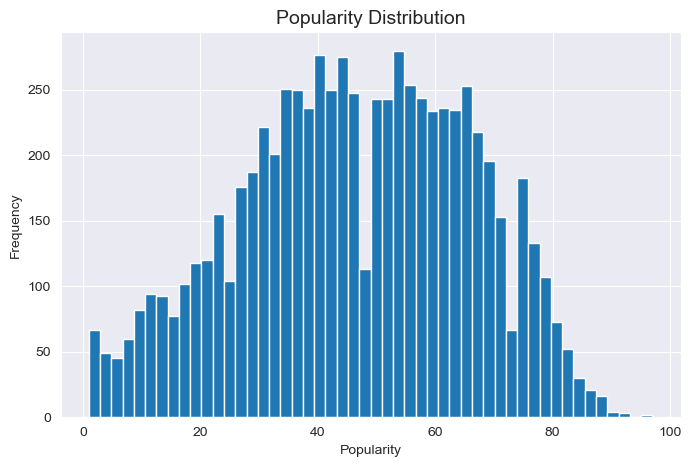

In [62]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = ordered['popularity_scores'].plot(kind='hist', bins=50)
_ = plt.xlabel('Popularity')
_ = plt.title('Popularity Distribution', fontsize=14)

To study this dynamic further, we can look at the statistical moments for the popularity column.

In [63]:
ordered[['popularity_scores']].describe()

,popularity_scores
count,7332.000000
mean,46.391844
std,19.565883
min,1.000000
25%,32.000000
50%,47.000000
75%,62.000000
max,97.000000


From the above we can see the low measures of centrality. The mean and median are both in the 40s and the IQR only extends to 62. Even songs of a medium popularity as defined in the classified dataset would be fairly rare. This makes sense given that popular radio is often branded as "Top 40" and there are thousands of songs in  the data, but the large imbalance will need to be accounted for later on.

<b>Correlations</b><br>

In [64]:
ordered.corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_scores
danceability,1.000000,0.355967,0.432359,0.253943,-0.370806,-0.450345,-0.027564,0.552342,-0.027316,-0.149608,0.289961
energy,0.355967,1.000000,0.801961,0.218504,-0.738664,-0.411300,0.194901,0.484420,0.207112,-0.026663,0.256343
loudness,0.432359,0.801961,1.000000,0.167866,-0.633010,-0.610792,0.136522,0.437774,0.193684,-0.096984,0.322229
speechiness,0.253943,0.218504,0.167866,1.000000,-0.208992,-0.158903,0.081885,0.134352,0.090175,-0.062927,0.072069
acousticness,-0.370806,-0.738664,-0.633010,-0.208992,1.000000,0.366573,-0.111749,-0.282367,-0.169555,0.077107,-0.313625
instrumentalness,-0.450345,-0.411300,-0.610792,-0.158903,0.366573,1.000000,-0.105587,-0.425739,-0.132303,0.047389,-0.347425
liveness,-0.027564,0.194901,0.136522,0.081885,-0.111749,-0.105587,1.000000,0.081201,0.028503,0.046222,0.006260
valence,0.552342,0.484420,0.437774,0.134352,-0.282367,-0.425739,0.081201,1.000000,0.114463,-0.093719,0.184823
tempo,-0.027316,0.207112,0.193684,0.090175,-0.169555,-0.132303,0.028503,0.114463,1.000000,-0.032889,0.084282
duration_ms,-0.149608,-0.026663,-0.096984,-0.062927,0.077107,0.047389,0.046222,-0.093719,-0.032889,1.000000,-0.129784


To also visualize these correlations, a heatmap is useful.

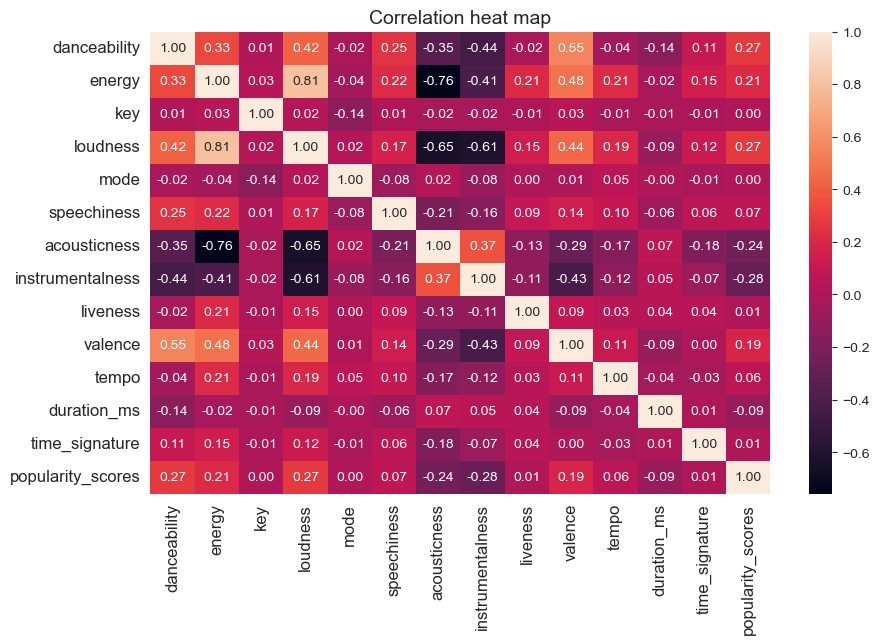

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
_ = sns.heatmap(song_data.corr(), annot=True, fmt=".2f",)
_ = plt.title('Correlation heat map', fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

From the above chart and heatmap, the correlations are mostly pretty weak. Energy, loudness, danceability, and valence have fairly strong relationships, which makes sense, and acousticness is naturally opposed to loudness and energy, but there's not much to go on outside of those. Unfortunately, this trend appears to hold true for the popularity variable. The correlation between loudness, danceability and popularity looks positive, but it would be nice to have a dependent variable that strongly relates to the target variable.

<b>Further examining specific variables</b><br>
Having established a general overview of the dependent and independent variables, the next step is to dive deeper into these relationships. The next several plots explore the relationship between certain features and the target variable. First, two functions are defined in order to create multiple plots.

In [66]:
def scat_plot(x, y, hue=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.scatterplot(x, y, hue=hue, s=12)
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.legend(fontsize=12)
    plt.show()
    
    
def regress_plot(x='', y='', data=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot with a regression line
    using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.regplot(x, y, data=data, scatter_kws={"s": 10}, line_kws={'color':'r'})
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.ylim(-3, 103)
    plt.show()

From the correlation heatmap, the best predictor seemed to be loudness. The newly defined `scat_plot` function can be used to examine it further.

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


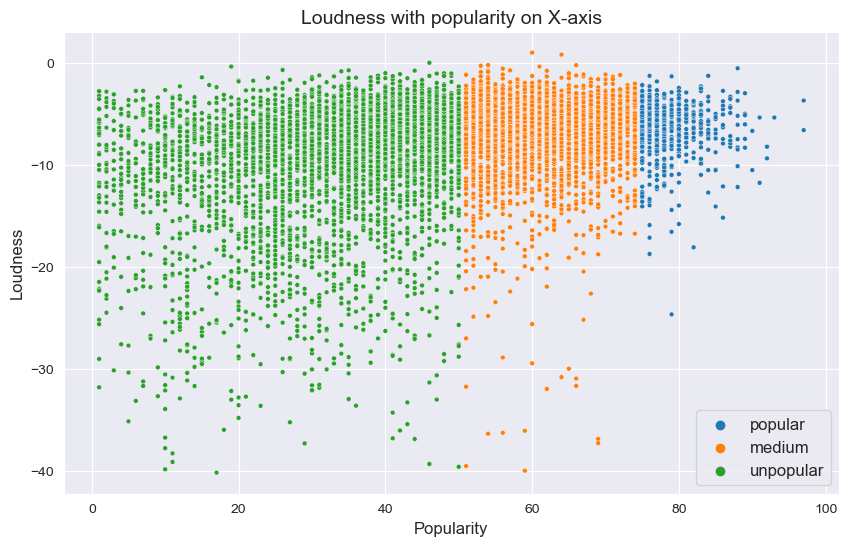

In [67]:
s = ordered

scat_plot(s.popularity_scores, s.loudness, hue=classified.popular_rating, xlab='Popularity',\
         ylab='Loudness', titl='Loudness with popularity on X-axis')

The plot above shows the distribution of loudness with popularity on the X-axis. It shows that the highest values of loudness can be found acoss the popularity spectrum, but as the X-axis increases the groupings become more and more concentrated toward the top. In other words, loudness doesn't guarantee popularity, but low levels of loudness seem to preclude popularity.<br>
<br>
Now with the `regress_plot` function:

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


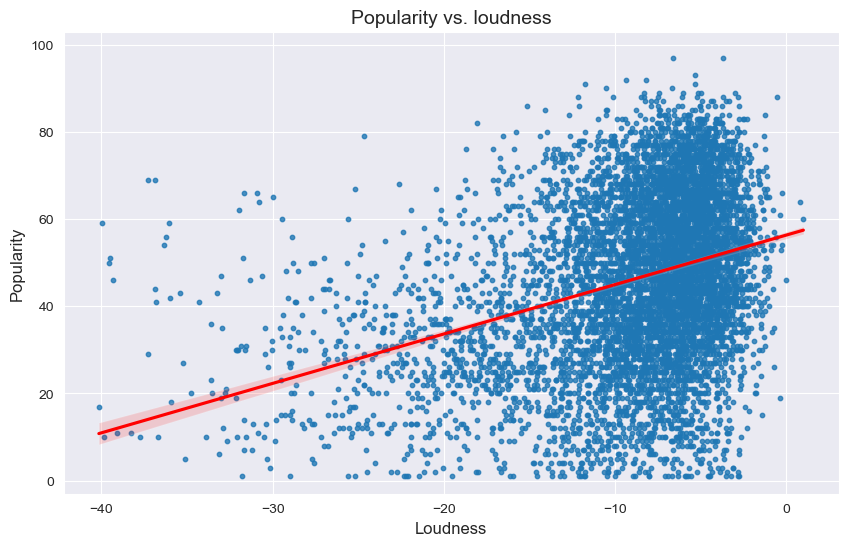

In [68]:
regress_plot('loudness', 'popularity_scores', data=s, xlab='Loudness',\
         ylab='Popularity', titl='Popularity vs. loudness')

The regressor clearly shows there is a positive correlation, and the data tends to narrow towards the top, but overall the observations are quite scattered. It's not a very strong fit.<br>
<br>
While loudness has the strongest correlation, for comparison sake, let's look at the other end of the spectrum with instrumentalness. Again, we can do so with both the `scat_plot` and `regress_plot`.

In [1]:
scat_plot(s.popularity_scores, s.instrumentalness, hue=classified.popular_rating, xlab='Popularity',\
         ylab='Instrumentalness', titl='Instrumentalness with popularity on X-axis')

NameError: name 'scat_plot' is not defined

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


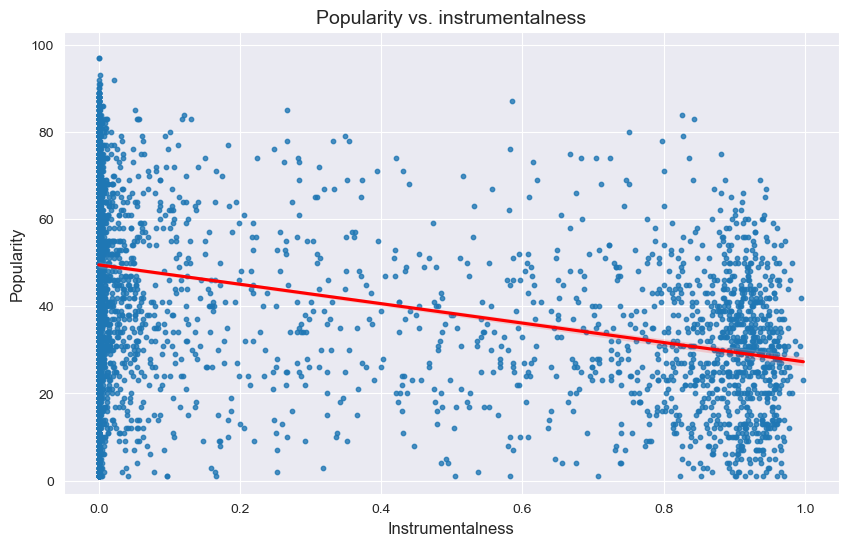

In [ ]:
regress_plot('instrumentalness', 'popularity_scores', data=s, xlab='Instrumentalness',\
         ylab='Popularity', titl='Popularity vs. instrumentalness')

Continuing to look at a couple other variables, we can quickly examine energy and danceability using subplots.

d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


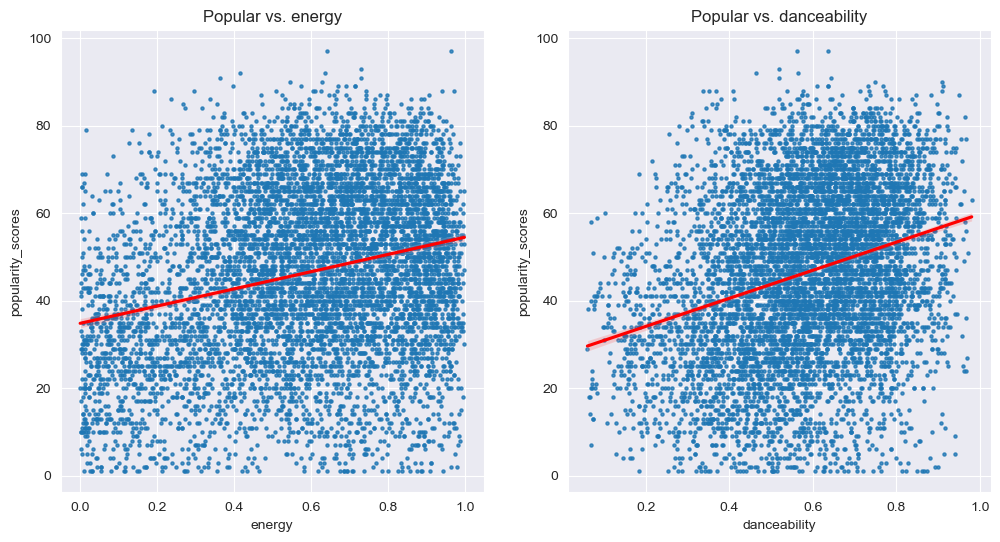

In [26]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1)
_ = sns.regplot(s.energy, s.popularity_scores, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Popular vs. energy')

ax2 = plt.subplot(1,2,2)
_ = sns.regplot(s.danceability, s.popularity_scores, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Popular vs. danceability')

The story for these variables is similar to the previous ones. 

In general, There is a lot of noise and variability amongst the observations. But honestly, thinking intuitively about song popularity, this shouldn't be too surprising. Unpopular songs and popular songs can have many similarities, and all popular songs can have many differences. The purpose of this project is to see if an algorithm can sort out these differences and similarities better than a human could. That is what the next section looks into.

## Modeling

<b>Section overview</b><br>
This sections outlines the steps used to find the best algorithm for predicting popularity. First, we
 wanted to set aside a few observations from a few popular artists to use as example cases to demonstrate the final model. With those removed from the full dataset, the next step was to run a <b>linear regression</b> model. As mentioned previously, the results were very poor. This is supported by the many visualizations above. To combat this problem, we decided to transition to a classification approach. After splitting the training and final test sets, done manually to ensure the imbalanced class ratios are preserved, we started simple by applying a <b>decision tree</b> model. From there, we worked my way up to ensemble methods using <b>bagging</b>, <b>Random Forest</b> and <b>boosting</b>, which improved the accuracy. 

### Linear Regression
With the example cases removed, the rest of the data is used here for training and testing a linear regression model using Scikit Learn. One important step is that the `ordered` dataset is shuffled to ensure that the song order does not introduce any bias, and the new shuffled data is stored as `reg_data`. For this initial test, to keep it as simple as possible, the categorical variables are omitted. 

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Set random state
state=25

# Shuffle the data
reg_data = ordered.sample(frac=1, random_state=state).reset_index(drop=True)

# First, try without categoricals
X = reg_data.select_dtypes(include='number').drop('popularity_scores', axis=1)
y = reg_data.popularity_scores

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

Now that the data has been split with `train_test_split`, we can fit the training data and calculate the R<sup>2</sup> score. This process, and all the similar ones to follow, is timed to get an understanding of the computational requirements for each model.<br>
<br>
In addition to the standard R<sup>2</sup> score, I also created a custom loss function to give a more concrete perspective on the model performance. This function, `custom_loss`, calculates counts for different levels of error between the predicted values and the actual test values, and also gives an overall average of the differences between predicted and actual.

In [72]:
def custom_loss(prediction, actual):
    paired = zip(prediction, actual)
    listed = list(paired)
    diffs = {'Under five': 0, 'Five to ten': 0, 'Over ten': 0, 'Average error': 0}
    sum = 0

    for pair in listed:
        sum += abs(pair[0] - pair[1])
        if abs(pair[0] - pair[1]) < 5:
            diffs['Under five'] += 1
        elif 5 <= abs(pair[0] - pair[1]) < 10:
            diffs['Five to ten'] += 1
        else:
            diffs['Over ten'] += 1
            
    diffs['Average error'] = sum / len(listed)
     
    return diffs

With the custom loss function set and the data split, we can begin running the models.

In [73]:
%%time

linreg = LinearRegression()
linreg.fit(X_train, y_train)

lin_pred = linreg.predict(X_test)

print(linreg.score(X_test, y_test))

0.15827329981342375
CPU times: total: 0 ns
Wall time: 8 ms


In [74]:
custom_loss(lin_pred, y_test)

{'Under five': 347,
 'Five to ten': 359,
 'Over ten': 1127,
 'Average error': 14.746157915280875}

The score for the model above is not very good. On the other hand, the custom metric isn't as bad as the score would lead one to believe.<br>
<br>
To take it a step further, let's see what happens when using the categoricals by using one hot encoding with `.get_dummies()`.

In [75]:
no_title = reg_data.drop(['song_title'], axis=1)
df_encoded = pd.get_dummies(no_title)
df_encoded.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'popularity_scores', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_0', 'mode_1', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

We can see above that the category variables have been separated into unique columns for each respective value. With the new data, new train and test splits need to be created, and the model re-run.

In [76]:
XX = df_encoded.drop('popularity_scores', axis=1)
yy = df_encoded.popularity_scores

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25, random_state=state)

Now fit and check the score:

In [34]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print(lr.score(X_test, y_test))

0.1526970466999099
CPU times: total: 46.9 ms
Wall time: 48 ms


And now the custom score:

In [77]:
custom_loss(lr_pred, y_test)

{'Under five': 355,
 'Five to ten': 354,
 'Over ten': 1124,
 'Average error': 14.746804979219835}

The result is better, but only marginally. To help ensure this result is accurate, cross-validation can be used.

In [78]:
from sklearn.model_selection import cross_val_score

# Use the regressor from above to set up the cross_val
cvals = cross_val_score(lr, XX, yy, cv=6)

# check the results
print(cvals)
print('The mean cross-validation score is: {num:.{dig}f}'.format\
      (num=np.mean(cvals), dig=4))

[0.18205019 0.19100925 0.19135713 0.19180954 0.14990918 0.1795664 ]
The mean cross-validation score is: 0.1810


The results are fairly similar across all of the folds, and the mean score is about the same as all of the previous results.

This seems to indicate that plain linear regression isn't well suited for this problem, which isn't surprising. To improve on it, I tried using ridge regression next.

### Ridge regression

In [79]:
%%time
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5, normalize=True)
ridge.fit(X_train, y_train)

print(ridge.score(X_test, y_test))

0.1517779521415481
CPU times: total: 31.2 ms
Wall time: 43 ms


d:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [80]:
custom_loss(ridge.predict(X_test), y_test)

{'Under five': 349,
 'Five to ten': 346,
 'Over ten': 1138,
 'Average error': 14.85369705056502}

This first attempt is worse than basic linear regression, but we can try to improve the result with grid-search cross validation.

In [81]:
from sklearn.model_selection import GridSearchCV

alphas = {'alpha': [0.0005, 0.0006, 0.00075, 0.0009, 0.001]}

rg = Ridge(normalize=True)

rg_cv = GridSearchCV(rg, alphas, cv=6)

rg_cv.fit(XX, yy)

print(rg_cv.best_params_)
print(rg_cv.best_score_)


d:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_

{'alpha': 0.001}
0.1809623468171068


d:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
d:\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_

<b>Plotting actual versus predicted values</b><br>
The plot below might give a clue as to why the linear models are performing so poorly. The range of predicted values is much narrower than the actual popularity values. This makes sense when thinking about linear regressions and recalling the plots from the data story report: The prediction is a single line through a cloud of observations. This is similar to what is seen in the plot below.

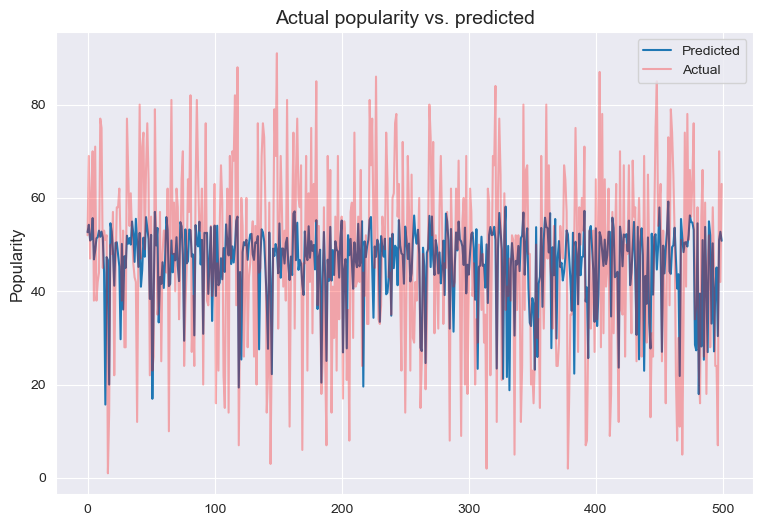

In [82]:
fig = plt.subplots(figsize=(9,6))
_ = plt.plot(list(rg_cv.predict(X_test))[:500], label='Predicted')
_ = plt.plot(list(y_test)[:500], c='r', alpha=0.3, label='Actual')
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Popularity', fontsize=12)
_ = plt.title('Actual popularity vs. predicted', fontsize=14)

### Classification
Because the regression models are not getting the job done, the next step is to use the `classified` dataset and try a classification approach.

<b>Class counts</b><br>
The different classes in the classified dataset exhibit a high level of imbalance. This needs to be accounted for in order to ensure the models perform as well as possible. Here's a visualization of the disparity.

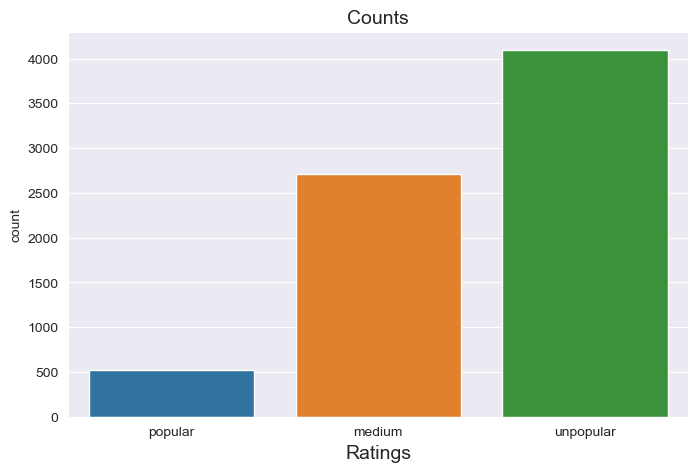

In [83]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = sns.countplot(x='popular_rating', data=classified)
_ = plt.xlabel('Ratings', fontsize=14)
_ = plt.title('Counts', fontsize=14)

##### Creating a balanced sample for the final test set
Instead of using a random sample for the final test set, here we manually create the test set in order to preserve the ratios of the labels.<br>
<br>
First, as before with the encoded dataframe from the regression model, we drop the `song_title` column and encode the categorical variables.

In [84]:
df = classified.drop(['song_title'], axis=1)
df = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'])
df.shape

(7332, 30)

Next, we create a separate dataframe with all the observations for each label, and then split each of those into train and test splits. All of the training splits and then all of the test splits are then stitched together so that all labels are represented in the data. Importantly, the popularity column is dropped completely to ensure that it is not included as a training feature.

In [85]:
from sklearn.model_selection import train_test_split

df_pop = df[df.popular_rating == 'popular']

df_med = df[df.popular_rating == 'medium']

df_unpop = df[df.popular_rating == 'unpopular']

# Set random seed
state=25

X_tr_p, X_ts_p, y_tr_p, y_ts_p = train_test_split(df_pop.drop(['popularity_scores', 'popular_rating'], axis=1),\
                                                 df_pop.popular_rating, test_size=0.15, random_state=state)

X_tr_m, X_ts_m, y_tr_m, y_ts_m = train_test_split(df_med.drop(['popularity_scores', 'popular_rating'], axis=1),\
                                                 df_med.popular_rating, test_size=0.15, random_state=state)

X_tr_up, X_ts_up, y_tr_up, y_ts_up = train_test_split(df_unpop.drop(['popularity_scores', 'popular_rating'], axis=1),\
                                                 df_unpop.popular_rating, test_size=0.15, random_state=state)

Here the training splits are merged to form one training set, stored as `training`, and then reshuffled to randomize the data. The output shows the shape of the training set.

In [86]:
pop_train = pd.concat([X_tr_p, y_tr_p], axis=1)
med_train = pd.concat([X_tr_m, y_tr_m], axis=1)
unpop_train = pd.concat([X_tr_up, y_tr_up], axis=1)

training = pd.concat([pop_train, med_train, unpop_train], axis=0)

training = training.sample(frac=1, random_state=state).reset_index(drop=True)

# Popularity has been removed, so only 30 columns
training.shape

(6230, 29)

The same process above is now executed with the final test data.

In [87]:
pop_test = pd.concat([X_ts_p, y_ts_p], axis=1)
med_test = pd.concat([X_ts_m, y_ts_m], axis=1)
unpop_test = pd.concat([X_ts_up, y_ts_up], axis=1)

final_test = pd.concat([pop_test, med_test, unpop_test], axis=0)

final_test = final_test.sample(frac=1, random_state=state).reset_index(drop=True)

final_test.shape

(1102, 29)

Now we have a training set of about 6250 observations, stored as `training`, and a test set of about 1100 rows, stored as `final_test`. With the data split, we can now train the models using the training data.

<b> Train and validation sets</b><br>
Before actually diving into the models, the training data needs to be further split into training and validation sets to allow testing without using the final test set.

In [88]:
X_class = training.drop('popular_rating', axis=1)
y_class = training.popular_rating

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.25, random_state=state)

#### Decision Tree
To start off simple, we first ran a basic decision tree classifier. This only generates one tree so it's not computationally intensive, but it's also susceptible to overfitting.

In [89]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Basic decision tree
dt = DecisionTreeClassifier(max_depth=20, random_state=state)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(accuracy_score(pred, y_test))

0.5288831835686778
CPU times: total: 141 ms
Wall time: 461 ms


For a basic out-of-the-box model, the accuracy score for the validation set isn't too bad. Now, we know that accuracy doesn't always tell the full story, especially with imbalanced data, but it's a good basic assessment to use while trying out the models before diving into other metrics, specifically precision and recall in this case. With that in mind, I decided to try some parameter tuning in order to improve the accuracy.

In [90]:
params = {'max_depth': [2, 10, 20, 40, 50],
         'min_samples_leaf': np.arange(1,10,2),}

dt = DecisionTreeClassifier(random_state=state)

dt_cv = GridSearchCV(dt, params, cv=6)

dt_cv.fit(X_class, y_class)

print(dt_cv.best_params_)
print('The average runtime is: ', np.mean(dt_cv.cv_results_['mean_fit_time']))
print('The best score is: ', dt_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 1}
The average runtime is:  0.0641519006093343
The best score is:  0.5781711393112418


The accuracy score improved a bit. Finally, let's test it on the validation set.

In [91]:
p = dt_cv.best_estimator_.predict(X_test)

print(accuracy_score(p, y_test))

0.5885750962772786


#### Bagging
The decision tree model, strictly from an accuracy perspective, performed fairly well. Next, we wanted to increase the complexity by using bagging to see if any further improvements could be made. 

In [93]:
%%time

from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=state)
bc = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=state)

bag_cv = cross_val_score(bc, X_class, y_class, cv=6)

print(bag_cv)
print('The mean cross-validation score is: {num:.{dig}f}'.format\
      (num=np.mean(bag_cv), dig=4))

[0.63041386 0.59769009 0.57899807 0.58092486 0.58574181 0.61849711]
The mean cross-validation score is: 0.5987
CPU times: total: 5.7 s
Wall time: 6.62 s


The accuracy for bagging is basically a little better than the single decision tree. Rather than spend a lot of time tweaking the model to squeeze out a few more accuracy points, we decided to move on to a new model.

#### Random Forest
Taking the tree models a step further, I next ran Random Forest.

In [94]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=state)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.5872913992297818
CPU times: total: 1.2 s
Wall time: 1.48 s


This time, the accuracy didn't improve, basically stayed same. Also, considering this is an ensemble method, the run time is decent.<br>
<br>
Now a little tuning with grid-search cross validation once again.

In [95]:
rf_params = {'n_estimators': [100, 300, 350],
            'max_depth': [2, 5, 100],
            'min_samples_leaf': [1, 2]}

rf_new = RandomForestClassifier(random_state=state)

rf_cv = GridSearchCV(rf_new, rf_params, n_jobs=-1, cv=6)

rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)

{'max_depth': 100, 'min_samples_leaf': 2, 'n_estimators': 350}


And then re-running the model with the updated parameters:

In [96]:
%%time

rf = RandomForestClassifier(max_depth=100, n_estimators=300, min_samples_leaf=1, random_state=state)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.5943517329910141
CPU times: total: 3.41 s
Wall time: 3.81 s


There is a clear increase in accuracy.

Below is a chart ranking the features in level of importance for the random forests model.

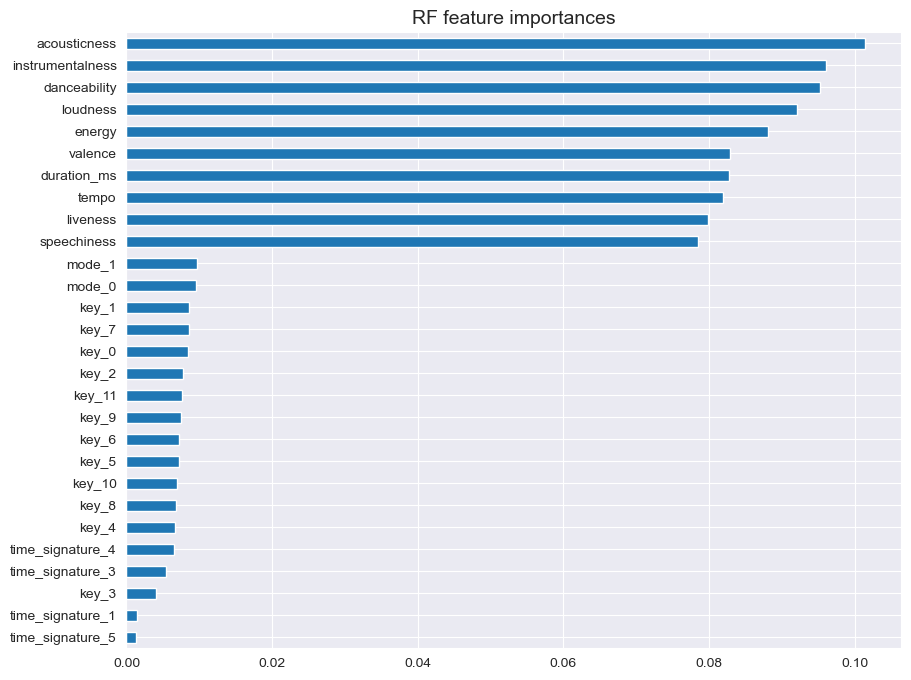

In [97]:
important = pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots(figsize=(10,8))
_ = important.plot(kind='barh')
_ = plt.title('RF feature importances', fontsize=14)

As the EDA section indicated, acousticness is the most important variable, followed by instrumentalness. Surprisingly the duration_ms is ranked highly as well. However, popular songs do tend to be of similar durations, and very long songs might hinder repeat listens, so it seems plausible that duration is important. The categorical variables all rank toward the bottom, but they are split up so their importance might be magnified when considered collectively. Ultimately, no single feature clearly dominates the rest. 

#### Gradient Boosting
Finally, we also ran Gradient Boosting to see if the model improves when running sequentially.

In [99]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=3, n_estimators=200, random_state=state)

gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)

print(accuracy_score(gb_pred, y_test))

0.6014120667522465
CPU times: total: 8.83 s
Wall time: 10.1 s


The result is a slight up grade from random forest.<br>
<br>
The accuracy seems to have plateaued, so it's time to dig in to some other metrics.

### Confusion matrix
More important than simple accuracy, the real value add of this project would be the ability to predict popular songs. This can be tested through a confusion matrix. For each of the tables below, the data point of interest is in the second column of the second row.

##### Bagging

In [100]:
from sklearn.metrics import confusion_matrix

bc.fit(X_train, y_train)

confusion_matrix(y_test, bc.predict(X_test))

array([[305,   0, 274],
       [ 74,   0,  38],
       [258,   0, 609]], dtype=int64)

##### Random forest

In [101]:
confusion_matrix(y_test, rf_pred)

array([[273,   1, 305],
       [ 61,   0,  51],
       [214,   0, 653]], dtype=int64)

##### Gradient Boosting

In [118]:
confusion_matrix(y_test, gb_pred)

array([[285,   5, 289],
       [ 66,   4,  42],
       [217,   2, 648]], dtype=int64)

They all scored good enough in the desired task of predicting popular songs.

#### Class weights
In an effort to make some improvements, the next move was to adjust the weights applied to the class labels. By applying larger weights to the minority classes, the idea is that the model will give those labels more emphasis. This way, we can direct the model to focus more on producing true positives for the class of interest.<br>
<br>
I first applied this to the bagging model to test the effect.

In [120]:
dt_bal = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=state)
gb_bal = GradientBoostingClassifier(max_depth=3, n_estimators=200, random_state=state)

gb_bal.fit(X_train, y_train)

bcb_p = gb_bal.predict(X_test)

print(accuracy_score(bcb_p, y_test))

0.6014120667522465


In [121]:
confusion_matrix(y_test, bcb_p)

array([[285,   5, 289],
       [ 66,   4,  42],
       [217,   2, 648]], dtype=int64)

Re-running bagging with balanced weights, the accuracy is much worse, but the recall for medium popularity songs is greatly improved. Encouraginly, the majority of the popular songs were predicted correctly, which is most important. Unfortunately, there are 340 false positives from the unpopular class to sift through now.

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bcb_p))

              precision    recall  f1-score   support

      medium       0.50      0.49      0.50       579
     popular       0.36      0.04      0.07       112
   unpopular       0.66      0.75      0.70       867

    accuracy                           0.60      1558
   macro avg       0.51      0.43      0.42      1558
weighted avg       0.58      0.60      0.58      1558



Using the above chart helps understand how well the model really worked. Of the 112 popular observations, 87 were predicted correctly for a recall of 78%. However, of the thousands of observations predicted as popular, only 87 truly were, leading to a precision of only 11% and an F1-score of only 0.19. <br>
<br>
Next is a re-run of random forest and Gradient Boost, but now with the balanced weights to see if further improvement is possible. For these we manually adjusted the weights to add additional emphasis on the popular class.

In [110]:
rf_b = RandomForestClassifier(max_depth=100, n_estimators=300, min_samples_leaf=1,\
                            class_weight={'medium': 2.475, 'popular': 100, 'unpopular': 1}, random_state=state)

rf_b.fit(X_train, y_train)

rfb_p = rf_b.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.5943517329910141


In [112]:
print(classification_report(y_test, rfb_p))

              precision    recall  f1-score   support

      medium       0.49      0.45      0.47       579
     popular       0.00      0.00      0.00       112
   unpopular       0.64      0.76      0.70       867

    accuracy                           0.59      1558
   macro avg       0.38      0.40      0.39      1558
weighted avg       0.54      0.59      0.56      1558



Less than ideal results.<br>
<br>
Now with boosting.

In [123]:
dt_bal = DecisionTreeClassifier(max_depth=2,\
                                class_weight={'medium': 2.475, 'popular': 150, 'unpopular': 1},\
                                random_state=state)

gb_bal = GradientBoostingClassifier(max_depth=3, n_estimators=200, random_state=state)

gb_bal.fit(X_train, y_train)

ad_bal_p = gb_bal.predict(X_test)

print(accuracy_score(ad_bal_p, y_test))

0.6014120667522465


In [125]:
print(classification_report(y_test, ad_bal_p))

              precision    recall  f1-score   support

      medium       0.50      0.49      0.50       579
     popular       0.36      0.04      0.07       112
   unpopular       0.66      0.75      0.70       867

    accuracy                           0.60      1558
   macro avg       0.51      0.43      0.42      1558
weighted avg       0.58      0.60      0.58      1558



These results are a little better than the ones for random forest, but it would be nice if the model predicted more popular songs. <br>
<br>
As it stands now, we think the bagging model best achieves it's goal. It's ultimately up to the stake holder, but the fact that the bagging model does the best at predicting popular songs is key, in our opinion. The performance likely isn't ideal, but for someone trying to sift through songs to pick out the best candidates, it's better to have to deal with only a few thousand as opposed to tens of thousands. Also, if these results were generalized to a new batch of songs only in the hundreds, then narrowing that down by 80-90% makes the task quite manageable.

### Applying the model to the hold-out set
Having tested several models, it's finally time to apply them to the final hold-out set to see if the results hold up. After splitting the `final_test` dataset into X and y variables, the data is applied to the bagging, random forest and AdaBoost models.

In [133]:
X_final = final_test.drop('popular_rating', axis=1)
y_final = final_test.popular_rating

holdout_p = bc_bal.predict(X_final)

print(accuracy_score(holdout_p, y_final))

0.5898366606170599


In [134]:
confusion_matrix(y_final, holdout_p)

array([[211,   4, 192],
       [ 56,   1,  23],
       [173,   4, 438]], dtype=int64)

In [135]:
print(classification_report(y_final, holdout_p))

              precision    recall  f1-score   support

      medium       0.48      0.52      0.50       407
     popular       0.11      0.01      0.02        80
   unpopular       0.67      0.71      0.69       615

    accuracy                           0.59      1102
   macro avg       0.42      0.41      0.40      1102
weighted avg       0.56      0.59      0.57      1102




Now with random forests:

In [136]:
rf_ho_p = rf_b.predict(X_final)

print(accuracy_score(rf_ho_p, y_final))

0.6098003629764065


In [137]:
confusion_matrix(y_final, rf_ho_p)

array([[188,   2, 217],
       [ 49,   0,  31],
       [130,   1, 484]], dtype=int64)

In [144]:
print(classification_report(y_final, rf_ho_p))

              precision    recall  f1-score   support

      medium       0.51      0.46      0.49       407
     popular       0.00      0.00      0.00        80
   unpopular       0.66      0.79      0.72       615

    accuracy                           0.61      1102
   macro avg       0.39      0.42      0.40      1102
weighted avg       0.56      0.61      0.58      1102



the performance is genrally the same.<br>
<br>
And finally, with gradient boosting:

In [145]:
adb_ho_p = gb_bal.predict(X_final)

print(accuracy_score(adb_ho_p, y_final))

0.5898366606170599


In [146]:
confusion_matrix(y_final, adb_ho_p)

array([[211,   4, 192],
       [ 56,   1,  23],
       [173,   4, 438]], dtype=int64)

In [148]:
print(classification_report(y_final, adb_ho_p))

              precision    recall  f1-score   support

      medium       0.48      0.52      0.50       407
     popular       0.11      0.01      0.02        80
   unpopular       0.67      0.71      0.69       615

    accuracy                           0.59      1102
   macro avg       0.42      0.41      0.40      1102
weighted avg       0.56      0.59      0.57      1102



The results for the final test data are generally the same as for the validation set.<br>
<br>
Based on the tests, the model appears to be generalizable and work comparably on unseen data. Now the trick is pitching to the stakeholder that the performance of this model would be beneficial.

## Conclusions

To recap, here is an overview of the performance of all the models ran.

#### Linear Regression Results
| Algorithm                             | Score  | Custom Loss Average | Execution Time |
|---------------------------------------|--------|---------------------|----------------|
| Linear Regression - No categoricals   | Fill |      Fill          |   Fill     |
| Linear Regression - With categoricals | Fill |       Fill         |    Fill     |
| Ridge Regression                      | Fill |       Fill        |    Fill     |

#### Classification Results
| Algorithm          | Validation Set Score | Validation Set Popular Recall | Hold Out Popular Recall | Execution Time |
|-------------------|----------------------|-------------------------------|-------------------------|----------------|
| Decision Tree     | Fill              | Fill                             | Fill                      | Fill         |
| Bagging           | Fill               | Fill                          | Fill                    | Fill         |
| Random Forest     | Fill               | Fill                         | Fill                    | Fill         |
| Gradient Boosting | Fill               | Fill                            | Fill                      | Fill     |

For the regression algorithms, there isn't much delineation in any category. As for the classification models, the difference depends on the metric. When it comes to basic accuracy they all performed more or less the same. The random forest model is slightly more precise than the rest, but that advantage is nullified by the poor predictive performance. Meanwhile, bagging technically has the lowest accuracy score, but it was far away the best at predicting popular songs. Additionally, the run time compares favorably with most of the models giving the bagging model a nice balance of effectiveness and computational performance. Based on the results above, I think it's clear that the bagging model is the best choice. // NOT SURE

### <b>Final Thoughts</b><br>
Thinking intuitively about the Spotify data and song popularity in general, it seems apparent that clear cut correlations between a song's features and its popularity would be difficult to discern. Two songs may be structured very similarly, and yet may have entirely different popularity scores. On the other side of the coin, two songs with the same popularity score may sound completely different. One song may be fast and the other slow; one may be loud while the other not so much. The EDA and the feature importances from above demonstrate that there isn't a clear set of features to pinpoint as a surefire predictor of popularity. This makes sense, because if there were a clear formula for increasing a song's popularity then every song would be popular which, inherently, is not possible.<br>
<br>
All of this speaks to the difficulty, perhaps even folly, of trying to predict song popularity, particularly through numeric data. There is just too much confounding information and too many factors that are difficult to quantify. For example, things like an artist's image, name recognition or unforeseen cultural trends all play a role in determining what is popular, and all of these are difficult or simply impossible to convey mathematically.<br>
<br>
On the other hand, the final model did seem to make some gains. It was able to predict most popular songs correctly, albeit with low total precision, and the results of the validation data were generalizable to the unseen hold out data. I think a music programmer or executive would benefit from the model. They would still need to sift through a number of unpopular songs to find the popular songs, but the total amount of work could potentially be greatly reduced. Perhaps this isn't quite the gain we were hoping for, but it is a net gain overall, which is at least part of the goal.